# Module 1: The Intelligent Agent Framework

**CS 440: Artificial Intelligence**

## Overview
In this module, we explore the foundational concepts of artificial intelligence through the lens of **intelligent agents**. We'll cover:
- Definitions of AI (thinking vs. acting; human vs. rational)
- PEAS descriptions (Performance, Environment, Actuators, Sensors)
- Environment properties (observability, determinism, etc.)
- Agent architectures: simple reflex, model-based, goal-based, and utility-based
- The Agent Function: mapping percept sequences to actions

## Drone Throughline
Throughout this course, we'll follow a **mining drone** deployed to collect resources from space. In Module 1, the drone operates in a small, discrete 2D grid containing "Resources" or "Empty Space". It functions as a simple reflex agent in a stochastic and partially observable environment, implementing an agent function that maps percepts to actions ("Drill" or "Move").

In [24]:
# Import essential libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from typing import List, Tuple, Dict, Any
import random
from enum import Enum
import time

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. What is Artificial Intelligence?

AI can be defined along two dimensions:
1. **Thinking vs. Acting**: Does the system reason internally, or does it produce external behavior?
2. **Human vs. Rational**: Should it emulate human cognition/behavior, or should it pursue optimal/correct reasoning?

This gives us four definitions:
- **Thinking Humanly**: Cognitive modeling approach
- **Thinking Rationally**: Laws of thought approach  
- **Acting Humanly**: Turing test approach
- **Acting Rationally**: Rational agent approach ← **Our focus**

### The Rational Agent Approach
An agent is **rational** if it selects actions that maximize its expected performance measure, given its percept sequence and built-in knowledge.

## 2. The Agent Function

The **agent function** is the mathematical mapping from any given percept sequence to an action:

$$f: P^* \rightarrow A$$

where $P^*$ is the set of all possible percept sequences, and $A$ is the set of actions.

### Key Concepts:
- **Percept**: The agent's immediate sensory input
- **Percept Sequence**: Complete history of everything the agent has perceived  
- **Action**: What the agent does in response
- **Agent Program**: Concrete implementation of the agent function running on a physical architecture

In [25]:
# Simple example: A thermostat agent function
# Maps percept (temperature) to action (heat on/off)

def thermostat_agent_function(percept_sequence: List[float], target_temp: float = 20.0) -> str:
    """
    Simple agent function for a thermostat.
    
    Args:
        percept_sequence: History of temperature readings
        target_temp: Desired temperature
    
    Returns:
        Action to take: "HEAT_ON" or "HEAT_OFF"
    """
    current_temp = percept_sequence[-1]  # Most recent percept
    
    if current_temp < target_temp:
        return "HEAT_ON"
    else:
        return "HEAT_OFF"

# Test the agent function
percept_history = [18.5, 18.7, 19.0, 19.2]
action = thermostat_agent_function(percept_history)
print(f"Current temperature: {percept_history[-1]}°C")
print(f"Action: {action}")

Current temperature: 19.2°C
Action: HEAT_ON


## 3. PEAS Description

To design an agent, we must specify its **PEAS**:
- **Performance measure**: How we evaluate the agent's success
- **Environment**: The world the agent operates in
- **Actuators**: How the agent acts on the environment
- **Sensors**: How the agent perceives the environment

### Example: Automated Taxi Driver

| Component | Description |
|-----------|-------------|
| **Performance** | Safe, fast, legal, comfortable trip; maximize profits |
| **Environment** | Roads, traffic, pedestrians, weather |
| **Actuators** | Steering, accelerator, brake, horn, display |
| **Sensors** | Cameras, GPS, speedometer, sonar, microphone |

## 4. Environment Properties

Different environments have different characteristics:

1. **Fully observable vs. Partially observable**: Can the agent see the complete state?
2. **Deterministic vs. Stochastic**: Do actions have guaranteed outcomes?
3. **Episodic vs. Sequential**: Are actions independent or do they affect future states?
4. **Static vs. Dynamic**: Does the environment change while the agent is deliberating?
5. **Discrete vs. Continuous**: Are there a finite number of states/actions?
6. **Single agent vs. Multi-agent**: Is the agent alone or are there others?
7. **Known vs. Unknown**: Does the agent know the laws of physics of the environment?

## 5. Drone Throughline: Mining Drone Environment

### PEAS Description for Our Mining Drone:

| Component | Description |
|-----------|-------------|
| **Performance** | Amount of ore collected from resources |
| **Environment** | Small, discrete 2D grid containing "Resources" or "Empty Space"; stochastic and partially observable |
| **Actuators** | Drill (extract ore), Move (navigate to adjacent cell) |
| **Sensors** | Location sensor, resource detector (may be noisy) |

### Environment Properties:
- **Partially observable**: The drone cannot see the entire grid
- **Stochastic**: Movement and sensing may be unreliable
- **Sequential**: Actions affect future state
- **Discrete**: Finite grid cells and actions
- **Single agent**: Only one drone (in Module 1)
- **Static**: Grid doesn't change during deliberation

Mining Environment Created!
Grid shape: (5, 5)


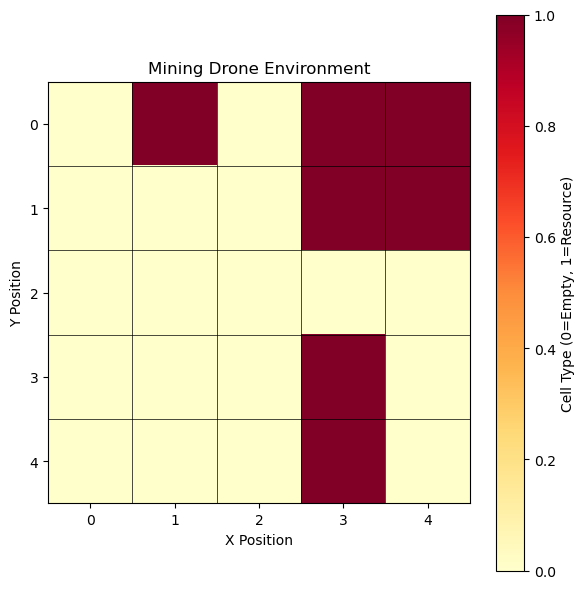

In [26]:
# Create the mining drone environment

class CellType(Enum):
    EMPTY = 0
    RESOURCE = 1

class MiningEnvironment:
    """2D grid environment for the mining drone."""
    
    def __init__(self, width: int = 5, height: int = 5, resource_prob: float = 0.3):
        """
        Initialize the mining environment.
        
        Args:
            width: Grid width
            height: Grid height
            resource_prob: Probability that a cell contains resources
        """
        self.width = width
        self.height = height
        self.grid = np.zeros((height, width), dtype=int)
        
        # Randomly place resources
        for i in range(height):
            for j in range(width):
                if random.random() < resource_prob:
                    self.grid[i][j] = CellType.RESOURCE.value
    
    def get_cell(self, x: int, y: int) -> int:
        """Get the type of cell at position (x, y)."""
        if 0 <= x < self.width and 0 <= y < self.height:
            return self.grid[y][x]
        return CellType.EMPTY.value
    
    def visualize(self):
        """Visualize the grid."""
        plt.figure(figsize=(6, 6))
        plt.imshow(self.grid, cmap='YlOrRd', interpolation='nearest')
        plt.colorbar(label='Cell Type (0=Empty, 1=Resource)')
        plt.title('Mining Drone Environment')
        plt.xlabel('X Position')
        plt.ylabel('Y Position')
        
        # Add grid lines
        for i in range(self.height + 1):
            plt.axhline(i - 0.5, color='black', linewidth=0.5)
        for j in range(self.width + 1):
            plt.axvline(j - 0.5, color='black', linewidth=0.5)
        
        plt.tight_layout()
        plt.show()

# Create and visualize environment
env = MiningEnvironment(width=5, height=5, resource_prob=0.3)
print("Mining Environment Created!")
print(f"Grid shape: {env.grid.shape}")
env.visualize()

## 6. Agent Architectures

There are four basic agent architectures, each building on the previous:

### 6.1 Simple Reflex Agent
- Selects actions based **only on the current percept**
- Ignores percept history
- Uses condition-action rules: "if condition then action"
- Works well in fully observable environments

**Skeleton:**
```
function SIMPLE-REFLEX-AGENT(percept) returns action
    static: rules, a set of condition-action rules
    
    state ← INTERPRET-INPUT(percept)
    rule ← RULE-MATCH(state, rules)
    action ← rule.ACTION
    return action
```

In [27]:
# Simple Reflex Agent for Mining Drone

class SimpleReflexDrone:
    """A simple reflex agent that acts based only on current percept."""
    
    def __init__(self):
        self.ore_collected = 0
    
    def perceive(self, environment: MiningEnvironment, x: int, y: int) -> Dict[str, Any]:
        """
        Perceive the current cell.
        
        Returns:
            Dictionary with percept information
        """
        cell_type = environment.get_cell(x, y)
        return {
            'position': (x, y),
            'has_resource': cell_type == CellType.RESOURCE.value
        }
    
    def agent_function(self, percept: Dict[str, Any]) -> str:
        """
        Agent function: Map percept to action.
        Uses simple condition-action rules.
        
        Returns:
            Action: "DRILL" or "MOVE"
        """
        # Simple rule: If there's a resource, drill. Otherwise, move.
        if percept['has_resource']:
            return "DRILL"
        else:
            return "MOVE"
    
    def execute_action(self, action: str, environment: MiningEnvironment, x: int, y: int):
        """Execute the chosen action."""
        if action == "DRILL":
            if environment.get_cell(x, y) == CellType.RESOURCE.value:
                self.ore_collected += 1
                environment.grid[y][x] = CellType.EMPTY.value  # Resource depleted
                print(f"  Drilled at ({x}, {y}). Ore collected: {self.ore_collected}")
            else:
                print(f"  Drilled at ({x}, {y}) but found nothing.")
        elif action == "MOVE":
            print(f"  Moving from ({x}, {y})...")

# Test the simple reflex agent
drone = SimpleReflexDrone()
test_percept = {'position': (2, 3), 'has_resource': True}
action = drone.agent_function(test_percept)
print(f"Percept: {test_percept}")
print(f"Action: {action}")

Percept: {'position': (2, 3), 'has_resource': True}
Action: DRILL


### 6.2 Model-Based Reflex Agent
- Maintains **internal state** to track aspects of the world not visible in the current percept
- Uses a **model** of how the world works (transition model + sensor model)
- Updates internal state based on:
  - Previous state
  - Action taken
  - Current percept

**Skeleton:**
```
function MODEL-BASED-REFLEX-AGENT(percept) returns action
    static: state, model, rules, action
    
    state ← UPDATE-STATE(state, action, percept, model)
    rule ← RULE-MATCH(state, rules)
    action ← rule.ACTION
    return action
```

In [28]:
# Model-Based Reflex Agent for Mining Drone

class ModelBasedDrone:
    """A model-based agent that maintains internal state."""
    
    def __init__(self, env_width: int, env_height: int):
        self.ore_collected = 0
        self.position = (0, 0)
        self.last_action = None
        
        # Internal model: what we believe about the world
        self.believed_map = np.full((env_height, env_width), -1)  # -1 = unknown
        self.visited_cells = set()
        
    def update_state(self, percept: Dict[str, Any]):
        """Update internal state based on percept and previous action."""
        self.position = percept['position']
        x, y = self.position
        
        # Update our belief about this cell
        if percept['has_resource']:
            self.believed_map[y][x] = CellType.RESOURCE.value
        else:
            self.believed_map[y][x] = CellType.EMPTY.value
        
        self.visited_cells.add((x, y))
    
    def agent_function(self, percept: Dict[str, Any]) -> str:
        """
        Agent function with internal state.
        Remembers which cells have been visited.
        """
        self.update_state(percept)
        
        # Rule: Drill if resource present
        if percept['has_resource']:
            self.last_action = "DRILL"
            return "DRILL"
        else:
            self.last_action = "MOVE"
            return "MOVE"
    
    def visualize_beliefs(self):
        """Visualize what the agent believes about the world."""
        plt.figure(figsize=(6, 6))
        # Use a custom colormap: gray for unknown, yellow for empty, red for resource
        display_map = np.copy(self.believed_map)
        display_map[display_map == -1] = -0.5  # Unknown cells
        
        plt.imshow(display_map, cmap='RdYlGn_r', interpolation='nearest', vmin=-0.5, vmax=1)
        plt.colorbar(label='Belief (-0.5=Unknown, 0=Empty, 1=Resource)')
        plt.title('Drone\'s Believed Map')
        plt.xlabel('X Position')
        plt.ylabel('Y Position')
        
        # Mark visited cells
        for (x, y) in self.visited_cells:
            plt.plot(x, y, 'b*', markersize=10)
        
        # Mark current position
        plt.plot(self.position[0], self.position[1], 'go', markersize=15, 
                markerfacecolor='none', markeredgewidth=2)
        
        plt.tight_layout()
        plt.show()

# Test the model-based agent
model_drone = ModelBasedDrone(env_width=5, env_height=5)
test_percept = {'position': (1, 1), 'has_resource': False}
action = model_drone.agent_function(test_percept)
print(f"Position: {model_drone.position}")
print(f"Action: {action}")
print(f"Visited cells: {model_drone.visited_cells}")

Position: (1, 1)
Action: MOVE
Visited cells: {(1, 1)}


### 6.3 Goal-Based Agent
- Has explicit **goals** that describe desirable situations
- Uses search and planning to find action sequences that achieve the goal
- More flexible than reflex agents (can adapt to new goals)
- Considers the future: "What will happen if I do action A?"

**Skeleton:**
```
function GOAL-BASED-AGENT(percept) returns action
    static: state, model, goal, action
    
    state ← UPDATE-STATE(state, action, percept, model)
    actions ← GENERATE-POSSIBLE-ACTIONS(state)
    action ← SELECT-ACTION(actions, state, goal)
    return action
```

In [29]:
# Goal-Based Agent for Mining Drone

class GoalBasedDrone:
    """A goal-based agent that plans to achieve explicit goals."""
    
    def __init__(self, env_width: int, env_height: int, goal_ore: int = 3):
        self.ore_collected = 0
        self.position = (0, 0)
        self.goal_ore = goal_ore  # Goal: collect this much ore
        self.believed_map = np.full((env_height, env_width), -1)
        self.visited_cells = set()
    
    def update_state(self, percept: Dict[str, Any]):
        """Update internal state."""
        self.position = percept['position']
        x, y = self.position
        
        if percept['has_resource']:
            self.believed_map[y][x] = CellType.RESOURCE.value
        else:
            self.believed_map[y][x] = CellType.EMPTY.value
        
        self.visited_cells.add((x, y))
    
    def goal_achieved(self) -> bool:
        """Check if goal is achieved."""
        return self.ore_collected >= self.goal_ore
    
    def agent_function(self, percept: Dict[str, Any]) -> str:
        """
        Goal-based agent function.
        Plans actions to achieve the goal of collecting ore.
        """
        self.update_state(percept)
        
        # If goal achieved, stop
        if self.goal_achieved():
            print(f"Goal achieved! Collected {self.ore_collected}/{self.goal_ore} ore.")
            return "STOP"
        
        # If current cell has resource, drill to make progress toward goal
        if percept['has_resource']:
            return "DRILL"
        else:
            # Move to find more resources
            return "MOVE"
    
    def execute_action(self, action: str, environment: MiningEnvironment):
        """Execute action in the environment."""
        x, y = self.position
        
        if action == "DRILL":
            if environment.get_cell(x, y) == CellType.RESOURCE.value:
                self.ore_collected += 1
                environment.grid[y][x] = CellType.EMPTY.value
                print(f"  Drilled! Ore: {self.ore_collected}/{self.goal_ore}")
        elif action == "MOVE":
            print(f"  Moving to search for resources...")

# Test goal-based agent
goal_drone = GoalBasedDrone(env_width=5, env_height=5, goal_ore=3)
print(f"Goal: Collect {goal_drone.goal_ore} ore")
print(f"Current progress: {goal_drone.ore_collected}/{goal_drone.goal_ore}")
print(f"Goal achieved: {goal_drone.goal_achieved()}")

Goal: Collect 3 ore
Current progress: 0/3
Goal achieved: False


### 6.4 Utility-Based Agent
- Has a **utility function** that maps states (or state sequences) to real numbers
- Measures "degree of happiness" or "quality" of outcomes
- Makes decisions that maximize **expected utility**
- Handles tradeoffs and uncertainty better than goal-based agents

**Key Concept:**
$$EU(a|e) = \sum_{s'} P(s'|a, e) \cdot U(s')$$

where:
- $EU(a|e)$ = expected utility of action $a$ given evidence $e$
- $P(s'|a, e)$ = probability of reaching state $s'$ given action $a$ and evidence $e$
- $U(s')$ = utility of state $s'$

**Skeleton:**
```
function UTILITY-BASED-AGENT(percept) returns action
    static: state, model, utility-function, action
    
    state ← UPDATE-STATE(state, action, percept, model)
    actions ← GENERATE-POSSIBLE-ACTIONS(state)
    action ← argmax_a EXPECTED-UTILITY(a, state, model, utility-function)
    return action
```

In [30]:
# Utility-Based Agent for Mining Drone

class UtilityBasedDrone:
    """A utility-based agent that maximizes expected utility."""
    
    def __init__(self, env_width: int, env_height: int):
        self.ore_collected = 0
        self.position = (0, 0)
        self.energy = 100  # Energy for movement
        self.believed_map = np.full((env_height, env_width), -1)
        
    def utility_function(self, ore: int, energy: int) -> float:
        """
        Utility function: measures quality of a state.
        
        Args:
            ore: Amount of ore collected
            energy: Remaining energy
        
        Returns:
            Utility value (higher is better)
        """
        # Utility = ore collected, but penalize low energy
        ore_utility = ore * 10  # Each ore worth 10 utility
        energy_penalty = -5 if energy < 20 else 0  # Penalty for low energy
        
        return ore_utility + energy_penalty
    
    def expected_utility(self, action: str, percept: Dict[str, Any]) -> float:
        """
        Calculate expected utility of an action.
        
        For simplicity, we'll use a basic calculation here.
        In a real system, this would consider probabilities of outcomes.
        """
        if action == "DRILL":
            if percept['has_resource']:
                # High probability of getting ore
                prob_success = 0.9
                utility_success = self.utility_function(self.ore_collected + 1, self.energy)
                utility_failure = self.utility_function(self.ore_collected, self.energy - 5)
                return prob_success * utility_success + (1 - prob_success) * utility_failure
            else:
                # Waste energy drilling nothing
                return self.utility_function(self.ore_collected, self.energy - 5)
        
        elif action == "MOVE":
            # Moving costs energy but might find resources
            return self.utility_function(self.ore_collected, self.energy - 2)
        
        return 0.0
    
    def agent_function(self, percept: Dict[str, Any]) -> str:
        """
        Utility-based agent function.
        Chooses action that maximizes expected utility.
        """
        actions = ["DRILL", "MOVE"]
        
        # Calculate expected utility for each action
        utilities = {action: self.expected_utility(action, percept) for action in actions}
        
        # Choose action with maximum expected utility
        best_action = max(utilities, key=utilities.get)
        
        print(f"  Action utilities: {utilities}")
        print(f"  Choosing: {best_action}")
        
        return best_action

# Test utility-based agent
utility_drone = UtilityBasedDrone(env_width=5, env_height=5)

# Test with resource present
test_percept_resource = {'position': (2, 2), 'has_resource': True}
print("Scenario 1: Resource present")
action1 = utility_drone.agent_function(test_percept_resource)
print()

# Test with no resource
test_percept_empty = {'position': (2, 2), 'has_resource': False}
print("Scenario 2: No resource")
action2 = utility_drone.agent_function(test_percept_empty)

Scenario 1: Resource present
  Action utilities: {'DRILL': 9.0, 'MOVE': 0}
  Choosing: DRILL

Scenario 2: No resource
  Action utilities: {'DRILL': 0, 'MOVE': 0}
  Choosing: DRILL


## 7. Simulation: Simple Reflex Drone in Action

Let's simulate our simple reflex drone navigating the mining environment with an animated visualization!

In [31]:
# Animated simulation of the simple reflex drone

def simulate_drone_animated(drone, environment: MiningEnvironment, steps: int = 15):
    """
    Simulate the drone with animated visualization.
    
    Args:
        drone: The agent to simulate
        environment: The mining environment
        steps: Number of simulation steps
    
    Returns:
        Animation object
    """
    # Track simulation state
    trajectory = [(0, 0)]  # Start position
    actions_taken = []
    grid_states = [np.copy(environment.grid)]
    
    x, y = 0, 0
    
    # Run simulation and record states
    for step in range(steps):
        # Perceive environment
        percept = drone.perceive(environment, x, y)
        
        # Choose action
        action = drone.agent_function(percept)
        actions_taken.append(action)
        
        # Execute action
        if action == "DRILL":
            if environment.get_cell(x, y) == CellType.RESOURCE.value:
                drone.ore_collected += 1
                environment.grid[y][x] = CellType.EMPTY.value
        elif action == "MOVE":
            # Simple movement: random walk
            moves = []
            if x > 0: moves.append((-1, 0))
            if x < environment.width - 1: moves.append((1, 0))
            if y > 0: moves.append((0, -1))
            if y < environment.height - 1: moves.append((0, 1))
            
            if moves:
                dx, dy = random.choice(moves)
                x, y = x + dx, y + dy
        
        trajectory.append((x, y))
        grid_states.append(np.copy(environment.grid))
    
    # Create animation
    fig, ax = plt.subplots(figsize=(8, 8))
    
    def init():
        ax.clear()
        return []
    
    def animate(frame):
        ax.clear()
        
        # Draw grid
        im = ax.imshow(grid_states[frame], cmap='YlOrRd', interpolation='nearest', vmin=0, vmax=1)
        
        # Add grid lines
        for i in range(environment.height + 1):
            ax.axhline(i - 0.5, color='black', linewidth=0.5)
        for j in range(environment.width + 1):
            ax.axvline(j - 0.5, color='black', linewidth=0.5)
        
        # Draw trajectory up to current frame
        if frame > 0:
            traj_x = [pos[0] for pos in trajectory[:frame+1]]
            traj_y = [pos[1] for pos in trajectory[:frame+1]]
            ax.plot(traj_x, traj_y, 'b-', alpha=0.3, linewidth=2)
        
        # Draw drone at current position
        curr_x, curr_y = trajectory[frame]
        ax.plot(curr_x, curr_y, 'go', markersize=20, markeredgewidth=3, markerfacecolor='lightgreen')
        
        # Add text info
        action_text = actions_taken[frame-1] if frame > 0 else "START"
        ax.set_title(f'Step {frame}/{steps} | Action: {action_text} | Ore Collected: {drone.ore_collected}', 
                    fontsize=14, fontweight='bold')
        ax.set_xlabel('X Position')
        ax.set_ylabel('Y Position')
        
        return [im]
    
    anim = FuncAnimation(fig, animate, init_func=init, frames=len(trajectory), 
                        interval=500, blit=True, repeat=True)
    
    plt.close()  # Prevent duplicate display
    return anim


def simulate_drone(drone, environment: MiningEnvironment, steps: int = 10):
    """
    Simulate the drone navigating the environment (text-based).
    
    Args:
        drone: The agent to simulate
        environment: The mining environment
        steps: Number of simulation steps
    """
    x, y = 0, 0  # Start position
    
    print("Starting simulation...")
    print(f"Initial environment:")
    environment.visualize()
    
    for step in range(steps):
        print(f"\n--- Step {step + 1} ---")
        
        # Perceive environment
        percept = drone.perceive(environment, x, y)
        print(f"Position: ({x}, {y})")
        print(f"Percept: {'RESOURCE' if percept['has_resource'] else 'EMPTY'}")
        
        # Choose action
        action = drone.agent_function(percept)
        print(f"Action: {action}")
        
        # Execute action
        if action == "DRILL":
            drone.execute_action(action, environment, x, y)
        elif action == "MOVE":
            # Simple movement: random walk
            moves = []
            if x > 0: moves.append((-1, 0))
            if x < environment.width - 1: moves.append((1, 0))
            if y > 0: moves.append((0, -1))
            if y < environment.height - 1: moves.append((0, 1))
            
            if moves:
                dx, dy = random.choice(moves)
                x, y = x + dx, y + dy
                print(f"  Moved to ({x}, {y})")
    
    print(f"\n{'='*50}")
    print(f"Simulation complete!")
    print(f"Total ore collected: {drone.ore_collected}")
    print(f"\nFinal environment:")
    environment.visualize()


# Run the animated simulation
np.random.seed(42)
random.seed(42)

sim_env = MiningEnvironment(width=5, height=5, resource_prob=0.3)
sim_drone = SimpleReflexDrone()

print("Creating animated simulation...")
animation = simulate_drone_animated(sim_drone, sim_env, steps=15)
HTML(animation.to_jshtml())

Creating animated simulation...


## 8. Comparison of Agent Architectures

Let's compare the different agent types:

| Architecture | State | Planning | Utility | Complexity | Best For |
|--------------|-------|----------|---------|------------|----------|
| **Simple Reflex** | None | No | No | Low | Fully observable, simple environments |
| **Model-Based** | Yes | No | No | Medium | Partially observable environments |
| **Goal-Based** | Yes | Yes | No | Medium-High | Environments requiring planning |
| **Utility-Based** | Yes | Yes | Yes | High | Complex tradeoffs, uncertain outcomes |

### Key Takeaways:
1. **Simple Reflex**: Fast but limited; only considers current percept
2. **Model-Based**: Tracks world state; handles partial observability
3. **Goal-Based**: Plans ahead; achieves explicit objectives
4. **Utility-Based**: Handles tradeoffs; maximizes expected utility

Our mining drone starts as a simple reflex agent, but as the course progresses and environments become more complex, we'll upgrade it to more sophisticated architectures!

## 9. Exercises

Try these exercises to reinforce your understanding:

### Exercise 1: PEAS Description
Create a PEAS description for a **robot vacuum cleaner**. Consider:
- What is its performance measure?
- What is its environment?
- What are its actuators?
- What are its sensors?

### Exercise 2: Environment Properties
Classify the following environments along the seven dimensions (fully/partially observable, deterministic/stochastic, etc.):
1. Chess game
2. Self-driving car
3. Weather prediction
4. Online shopping recommendation system

### Exercise 3: Modify the Agent
Modify the `SimpleReflexDrone` to implement a new rule:
- If the drone has collected 3 or more ore, it should return "RETURN_HOME" instead of "MOVE"
- Test your modified agent

### Exercise 4: Agent Function
Write the agent function for a simple thermostat that:
- Turns heat ON if temperature < 18°C
- Turns heat OFF if temperature > 22°C
- Does nothing if temperature is between 18-22°C (hysteresis)

In [ ]:
# Exercise 3: Your solution here
# Modify the SimpleReflexDrone to return home after collecting 3 ore

class ImprovedReflexDrone(SimpleReflexDrone):
    """Extended simple reflex drone with return-home behavior."""
    
    def agent_function(self, percept: Dict[str, Any]) -> str:
        """
        Agent function with return-home rule.
        TODO: Implement the return home logic
        """
        # Your code here
        pass

# Test your solution
# improved_drone = ImprovedReflexDrone()
# test_percept = {'position': (2, 3), 'has_resource': False}
# improved_drone.ore_collected = 3  # Simulate having collected 3 ore
# action = improved_drone.agent_function(test_percept)
# print(f"Action with 3 ore collected: {action}")  # Should be "RETURN_HOME"

In [ ]:
# Exercise 4: Your solution here
# Implement a thermostat with hysteresis

def hysteresis_thermostat(percept_sequence: List[float], 
                          low_threshold: float = 18.0,
                          high_threshold: float = 22.0,
                          current_state: str = "OFF") -> str:
    """
    Thermostat agent function with hysteresis.
    
    Args:
        percept_sequence: History of temperature readings
        low_threshold: Turn heat ON below this temperature
        high_threshold: Turn heat OFF above this temperature
        current_state: Current state of heater ("ON" or "OFF")
    
    Returns:
        Action: "HEAT_ON", "HEAT_OFF", or "NO_CHANGE"
    
    TODO: Implement the hysteresis logic
    """
    # Your code here
    pass

# Test your solution
# temps = [17.5, 18.5, 20.0, 21.5, 22.5]
# state = "OFF"
# for temp in temps:
#     action = hysteresis_thermostat([temp], current_state=state)
#     print(f"Temp: {temp}°C, Current: {state}, Action: {action}")

## 10. Key Concepts Summary

### Agent Function (Mathematical Foundation)
The agent function $f: P^* \rightarrow A$ maps percept sequences to actions. This is the core mathematical abstraction of intelligence.

### PEAS Framework
Always specify:
- **P**erformance measure (objective)
- **E**nvironment (world)
- **A**ctuators (actions)
- **S**ensors (percepts)

### Four Agent Architectures
1. **Simple Reflex**: Condition-action rules, no state
2. **Model-Based**: Maintains internal state, tracks world
3. **Goal-Based**: Plans to achieve explicit goals
4. **Utility-Based**: Maximizes expected utility, handles tradeoffs

### Environment Properties
Classify environments along 7 dimensions to determine appropriate agent architecture:
- Observable vs. Partially Observable
- Deterministic vs. Stochastic
- Episodic vs. Sequential
- Static vs. Dynamic
- Discrete vs. Continuous
- Single vs. Multi-agent
- Known vs. Unknown

## 11. Looking Ahead

### Module 2 Preview: Problem Solving and Search
In the next module, our drone will face a more complex environment:
- **Expanded mission**: Vast, deterministic asteroid field
- **New challenges**: Resources far apart, navigation is costly
- **Upgraded agent**: Problem-solving agent using A* search
- **New concepts**: State-space graphs, heuristics, constraint satisfaction

The simple reflex agent won't suffice anymore. We'll need **search algorithms** to plan optimal paths through space!

### The Journey Continues
As we progress through the course, the drone's environment will become increasingly challenging:
- Module 3: Multi-agent competition (adversarial search)
- Module 4: Complex logical rules (first-order logic)
- Module 5: Sensor noise and uncertainty (probabilistic reasoning)
- Module 6: Long-term planning with tradeoffs (decision theory)
- Module 7: Completely unknown environments (learning)

Each module builds on the foundation we've established here with the intelligent agent framework.

## 12. References and Further Reading

### Primary Textbook
- Russell, S. J., & Norvig, P. (2020). *Artificial Intelligence: A Modern Approach* (4th ed.). Pearson.
  - Chapter 1: Introduction (Sections 1.1-1.3)
  - Chapter 2: Intelligent Agents (Sections 2.1-2.4)

### Key Sections Referenced
- **[1.1]** What is AI? Four definitions
- **[2.1]** Agents and environments, agent function
- **[2.3]** Environment properties, PEAS descriptions
- **[2.4]** Agent architectures (reflex, model-based, goal-based, utility-based)

### Additional Resources
- Wooldridge, M. (2009). *An Introduction to MultiAgent Systems* (2nd ed.). Wiley.
- Artificial Intelligence: Foundations of Computational Agents (online textbook): https://artint.info/

### Online Resources
- Stanford CS221: Artificial Intelligence: Principles and Techniques
- MIT 6.034: Artificial Intelligence
- UC Berkeley CS188: Introduction to Artificial Intelligence

---

**Congratulations!** You've completed Module 1: The Intelligent Agent Framework. You now understand the fundamental concepts that underpin all AI systems. In the next module, we'll give our drone the ability to search and plan!